# Time series forecasting

This notebooks demonstrates skills of univariate and multivariate forecasting using the sktime library (built on top of sklearn)


In this use-case, a temporal cross-validator strategy with expanding window is implemented. This strategy required the implementation of a new child class of `BaseSplitter` from `sklearn.forecasting.model_evaluation`. This class is capable of performing cross validation on windows with specified cutoffs, while keeping all of the past observations for training.

In [1]:
from sk_utils import *

In [2]:
from sktime.datasets import load_longley
from sktime.forecasting.compose import ColumnEnsembleForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.trend import PolynomialTrendForecaster
import custom_spliters as cs

In [3]:
from joblib import Parallel, delayed
import itertools
from functools import partial
import pandas_utils as pdu
from sktime.forecasting.model_evaluation import evaluate

In [17]:
#setup default plot sizes for jupyter
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (10,5)

In [5]:
#this is the multivariate dataset
#our target is to accurately predict all variables
_, y = load_longley()
y

,GNPDEFL,GNP,UNEMP,ARMED,POP
Period,,,,,
1947,83.0,234289.0,2356.0,1590.0,107608.0
1948,88.5,259426.0,2325.0,1456.0,108632.0
1949,88.2,258054.0,3682.0,1616.0,109773.0
1950,89.5,284599.0,3351.0,1650.0,110929.0
1951,96.2,328975.0,2099.0,3099.0,112075.0
1952,98.1,346999.0,1932.0,3594.0,113270.0
1953,99.0,365385.0,1870.0,3547.0,115094.0
1954,100.0,363112.0,3578.0,3350.0,116219.0
1955,101.2,397469.0,2904.0,3048.0,117388.0


In [6]:
#here is the instanciation of a Custom splitter, implemented in custom_splitters.py
cv = cs.CustomSplitter(
    cutoffs = y.index[-8:-3:]
    , fh = [1,2,3]
)

Number of Folds = 5


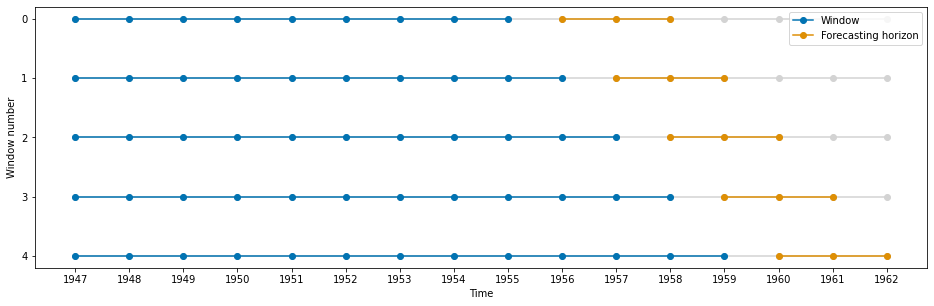

In [7]:
#a graphical representation of the cross validation windows (same as folds)
n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")
train_windows, test_windows = get_windows(y.iloc[:,0], cv)
plot_windows(y, train_windows, test_windows)

In [9]:
#setup the parallel dispatcher
n_jobs = 4
pre_dispatch="2*n_jobs"
backend="loky"

parallel = Parallel(
            n_jobs=n_jobs, pre_dispatch=pre_dispatch, backend=backend
    )

In [10]:
#make the dataset larger to test for runtime performance
_, y = load_longley()
# y = y.join(y, rsuffix='_1').join(y, rsuffix='_2').join(y, rsuffix='_3')
# y = y.join(y, rsuffix='_a')

### Backtesting

In [11]:
from sktime.forecasting.compose import EnsembleForecaster
from sktime.forecasting.tbats import TBATS
from sktime.forecasting.var import VAR

In [13]:
#first, the setup

#define the forecasterss
forecasters = [ 
    #list of univariate forecasters
    ExponentialSmoothing(trend="add")
    , ExponentialSmoothing(trend="mul")
    , ExponentialSmoothing()
    
    #and a multivariate one
    , VAR()
]

#and an ensemble forecaster that combines predictions from univariate predictors
ensemble = EnsembleForecaster(forecasters = [
                ("ExponentialSmoothing1", ExponentialSmoothing(trend="mul")),
                ("ExponentialSmoothing2", ExponentialSmoothing())
            ],
            aggfunc = "mean")

forecasters.append(ensemble)

#setup the partial function for backtesting
#y and cv are the same for all forecasters, so we can build a partial function to avoid input duplication
backtest_partial = partial(backtest, y, cv)

The following method performs backtesting using the forecasters specified and the cross-validator created in the first section.
The backtesting is done in parallel.

It returns the cross validation predictions and all the final fitted models.

In [14]:
%%time
fitted_forecasters, cross_val_preds = full_backtest(
    forecasters
    , backtest_partial
    , y
    , parallel
)

In [35]:
#total number of fitted models:
#we are fitting one more per id, per fold, per method
len(cross_val_preds.groupby('id fold method'.split()).groups)

125

The `plot_predictions` method takes the `cross_val_preds` dataframe and displays the forecasts for a given series id and a given fold at a time, along with the true values

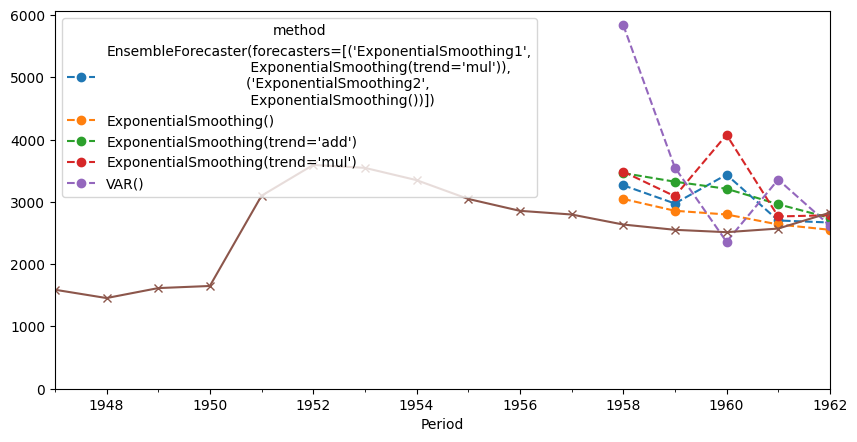

In [18]:
plot_predictions(y
                 , 'ARMED' #the target variable
                 , cross_val_preds #the cross validated predictions
                 , gap=3 #the gap (=forecast horizon)
                )


### Evaluation

In [21]:
from evaluate import *

In [22]:
metric_to_sort_by = 'mean_absolute_percentage_error'

#these are the metrics per prediction gap (horizon)
metrics_per_gap = (cross_val_preds
    .groupby('gap method'.split())
    .apply(get_metrics)
    .apply(pd.Series)
    .sort_values(by=f'gap {metric_to_sort_by}'.split())
)

#these are the metrics per prediction gap and forecasting window (fold)
metrics_per_gap_fold = (cross_val_preds
    .groupby('gap fold method'.split())
    .apply(get_metrics)
    .apply(pd.Series)
    .sort_values(by=f'gap fold {metric_to_sort_by}'.split())
)

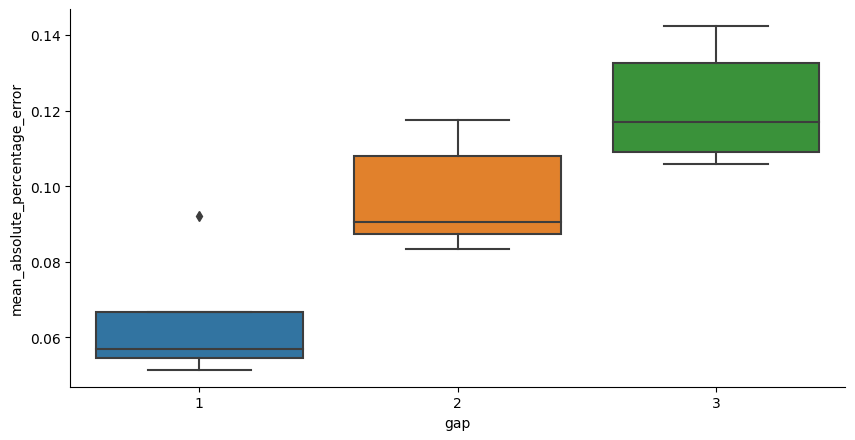

In [32]:
#evolution of the MAPE with the distance to the prediction
_ = sns.boxplot(
    data = metrics_per_gap.reset_index()
    , x = 'gap'
    , y = metric_to_sort_by
)
sns.despine()

#as expected, the error grows as the distance to the prediction increases

In [33]:
#these are the top performing methods per gap
top_performers = dict(metrics_per_gap.groupby('gap').head(1).index)
top_performers

{1: "ExponentialSmoothing(trend='mul')",
 2: "ExponentialSmoothing(trend='mul')",
 3: "ExponentialSmoothing(trend='mul')"}

In [34]:
#these are all the top forecasters fitted
fitted_forecasters.loc[:, set(top_performers.values())]

,ExponentialSmoothing(trend='mul')
GNPDEFL,ExponentialSmoothing(trend='mul')
GNP,ExponentialSmoothing(trend='mul')
UNEMP,ExponentialSmoothing(trend='mul')
ARMED,ExponentialSmoothing(trend='mul')
POP,ExponentialSmoothing(trend='mul')
multivariate,ExponentialSmoothing(trend='mul')


## TODO:
- Create the dataset to explore hierarchies and grouped forecasting
- Add an imputer that clears all initial NaNs up to the first value > 0
- Train an ensemble learner that uses predictions from surrogate models

## Statsforecast test

StatsForecast claim to have a much faster implementation on univariate predictors. 

I am, however, unable to reproduce their run times for larger series.

In [1]:
from statsforecast.core import StatsForecast
from statsforecast.models import auto_arima

In [2]:
import time

In [3]:
import pandas as pd
train = pd.read_csv('M4-Hourly.csv')
test = pd.read_csv('M4-Hourly-test.csv').rename(columns={'y': 'y_test'})

In [4]:
series = train.unique_id.unique()[:10]

In [5]:
models = [(auto_arima, 24)]

In [24]:
fcst = StatsForecast(train.set_index('unique_id ds'.split()).loc[:, 600:,:].reset_index('ds')
                     #train.set_index('unique_id').loc[series]
                     , models=models
                     , freq='H'
                     , n_jobs=10
                    )

In [25]:
st_time = time.time()
forecasts = fcst.forecast(4)
time.time()-st_time

2606.2058057785034